In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
class KArmedTestbed:
    """Environment for multi-armed bandit problems."""
    def __init__(self, k: int):
        self.k = k
        self.q = np.random.randn(k) # randomly generate action values

    @property
    def best_action(self):
        return np.argmax(self.q)
    
    def step(self, action):
        """(observation, reward, done, info)"""
        reward = np.random.randn() + self.q[action]
        return (None, reward, None, None)

    
class AgentEpsGreedy:
    """Epsilon-greedy agent."""
    def __init__(self, k, eps):
        self.q = np.zeros(k)
        self.n = np.zeros(k)
        self.k = k
        self.eps = eps

    def reset(self):
        self.q = np.zeros(k)
        self.n = np.zeros(k)

    def policy(self, observation=None):
        """Given an observation of the environment's state, determine how to act.
        Note: for bandit problems, there is nothing to observe, since there is
        only a single environment state; hence, `observation` will not be used
        here.
        """
        if np.random.uniform() < self.eps: # act exploratorily
            return np.random.choice(range(self.k))
        else: # act greedily
            return np.argmax(self.q)
    
    def update_q(self, action, obs_reward):
        """Update the agent's estimate Q(a) based on an observed reward."""
        self.n[action] += 1
        self.q[action] += (obs_reward - self.q[action]) / self.n[action]

In [131]:
def simulate_run(env, agent):
    n_steps = 1_000
    trajectories = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps, dtype=int),
    }
    for i in range(n_steps):
        # select action
        a = agent.policy()
        # take action
        _, r, _, _ = env.step(a)
        # update agent's internal estimate of Q(a)
        agent.update_q(a, r)

        # update trajectories
        trajectories['reward'][i] = r
        trajectories['optimal_action'][i] = int(a == env.best_action)
    
    return trajectories

In [132]:
def cumavg(x: np.ndarray):
    """Take the cumulative average of a vector of numbers."""
    if x.ndim != 1:
        raise ValueError('Input array must be a vector.')
    return np.cumsum(x) / np.arange(1, len(x)+1, 1)

Don't use cumavg on the results, but average over the iterations.

In [192]:
results = []
for eps, color in [
    (0.1, 'blue'),
    (0.01, 'red'),
    (0, 'green'),
    ]:

    traj_accum = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps),
    }
    
    k = 10
    n_runs = 2_000

    for i_run in range(n_runs):
        # perform a run
        env = KArmedTestbed(k)
        agent = AgentEpsGreedy(k, eps)
        traj = simulate_run(env, agent)
        # record run results
        traj_accum['reward'] += traj['reward']
        traj_accum['optimal_action'] += traj['optimal_action']

    traj_accum['reward'] /= n_runs
    traj_accum['optimal_action'] /= n_runs
    traj_accum['epsilon'] = eps
    results.append(traj_accum)

In [193]:
import matplotlib.pyplot as plt

def plot_trajectories_testbed(trajectories: dict[str, np.ndarray], ax=None, param_name: str = None):
    if ax is None:
        _, ax = plt.subplots(nrows=2, figsize=(10,10))
    
    param_name = param_name or 'epsilon'
    
    xticks_ = np.arange(0, 1000+1, 250)

    colors = ('blue', 'red', 'green')
    for idx, traj_dict in enumerate(trajectories):
        label_ = r"$\varepsilon = $" + str(traj_dict[param_name])
        ax[0].plot(traj_dict['reward'], color=colors[idx], label=label_)
        ax[1].plot(traj_dict['optimal_action'], color=colors[idx], label=label_)

    ax[0].set(ylim=[0,1.5], yticks=[0, 0.5, 1.0, 1.5], yticklabels=[0, 0.5, 1, 1.5], xticks=xticks_, xticklabels=xticks_)
    ax[0].set_xlabel(xlabel="Steps", fontsize=15)
    ax[0].set_ylabel(ylabel="Average\nreward", rotation=0, fontsize=15)
    ax[0].yaxis.set_label_coords(-.15, .5)
    ax[0].legend()

    yticks_ = np.arange(0, 1.0+.1, .20)
    yticklabels_ = [ f"{int(100*tick)}%" for tick in yticks_]
    ax[1].set(ylim=[0,1.0], yticks=yticks_, yticklabels=yticklabels_, xticks=xticks_, xticklabels=xticks_)
    ax[1].set_xlabel(xlabel="Steps", fontsize=15)
    ax[1].set_ylabel(ylabel="%\nOptimal\naction", rotation=0, fontsize=15)
    ax[1].yaxis.set_label_coords(-.15, .5)
    ax[1].legend()

    plt.show()

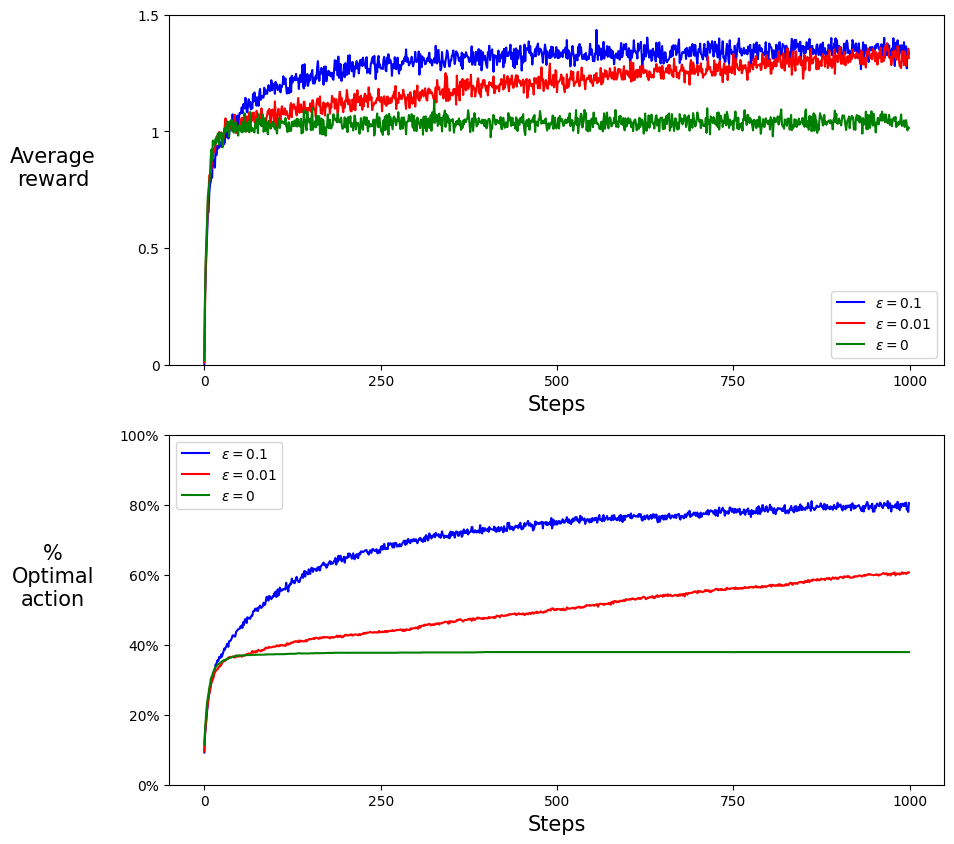

In [194]:
plot_trajectories_testbed(trajectories=results)

# 2.5 Nonstationary Problems

Make the environment means move slowly over time

In [268]:
class KArmedTestbed:
    """Environment for multi-armed bandit problems."""
    def __init__(self, k: int, mean_baseline=0):
        self.k = k
        self.q = np.random.randn(k) + mean_baseline # randomly generate action values

    @property
    def best_action(self):
        return np.argmax(self.q)
    
    def step(self, action):
        """(observation, reward, done, info)"""
        reward = np.random.randn() + self.q[action]
        return (None, reward, None, None)
    
    def evolve(self):
        """Randomly perturb the reward distributions."""
        self.q += np.sqrt(0.01) * np.random.randn(self.k)

def simulate_run_nonstationary(env, agent):
    n_steps = 10_000
    trajectories = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps, dtype=int),
    }
    for i in range(n_steps):
        # select action
        a = agent.policy()
        # take action
        _, r, _, _ = env.step(a)
        # evolve environment
        env.evolve()
        # update agent's internal estimate of Q(a)
        agent.update_q(a, r)

        # update trajectories
        trajectories['reward'][i] = r
        trajectories['optimal_action'][i] = int(a == env.best_action)
    
    return trajectories

class AgentEpsGreedy:
    """Epsilon-greedy agent."""
    def __init__(self, k, eps, alpha=None, q0=0):
        self.q = q0 * np.ones(k)
        self.n = np.zeros(k)
        self.k = k
        self.eps = eps
        self.alpha = alpha

    def reset(self):
        self.q = np.zeros(k)
        self.n = np.zeros(k)

    def policy(self, observation=None):
        """Given an observation of the environment's state, determine how to act.
        Note: for bandit problems, there is nothing to observe, since there is
        only a single environment state; hence, `observation` will not be used
        here.
        """
        if np.random.uniform() < self.eps: # act exploratorily
            return np.random.choice(range(self.k))
        else: # act greedily
            return np.argmax(self.q)
    
    def update_q(self, action, obs_reward):
        """Update the agent's estimate Q(a) based on an observed reward."""
        self.n[action] += 1
        step_size = self.alpha or 1/self.n[action]
        self.q[action] += (obs_reward - self.q[action]) * step_size

In [230]:
results = []
colors = ('blue', 'red')
n_steps = 10_000
# sample averaging
traj_accum = {
    'reward': np.zeros(n_steps),
    'optimal_action': np.zeros(n_steps),
}
    
k = 10
n_runs = 500
eps = 0.1
for i_run in range(n_runs):
    # perform a run
    env = KArmedTestbed(k)
    agent = AgentEpsGreedy(k, eps)
    traj = simulate_run_nonstationary(env, agent)
    # record run results
    traj_accum['reward'] += traj['reward']
    traj_accum['optimal_action'] += traj['optimal_action']

traj_accum['reward'] /= n_runs
traj_accum['optimal_action'] /= n_runs
traj_accum['epsilon'] = eps
results.append(traj_accum)

# constant step size
traj_accum = {
    'reward': np.zeros(n_steps),
    'optimal_action': np.zeros(n_steps),
}
    
k = 10
n_runs = 200

for i_run in range(n_runs):
    # perform a run
    env = KArmedTestbed(k)
    agent = AgentEpsGreedy(k, eps, alpha=0.1)
    traj = simulate_run_nonstationary(env, agent)
    # record run results
    traj_accum['reward'] += traj['reward']
    traj_accum['optimal_action'] += traj['optimal_action']

traj_accum['reward'] /= n_runs
traj_accum['optimal_action'] /= n_runs
traj_accum['epsilon'] = 0.1
results.append(traj_accum)

/var/folders/ny/61f167pd0bn5z0strfpmwd4m0000gp/T/ipykernel_60348/493505107.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set(yticklabels=[0, 0.5, 1, 1.5], xticks=xticks_, xticklabels=xticks_)


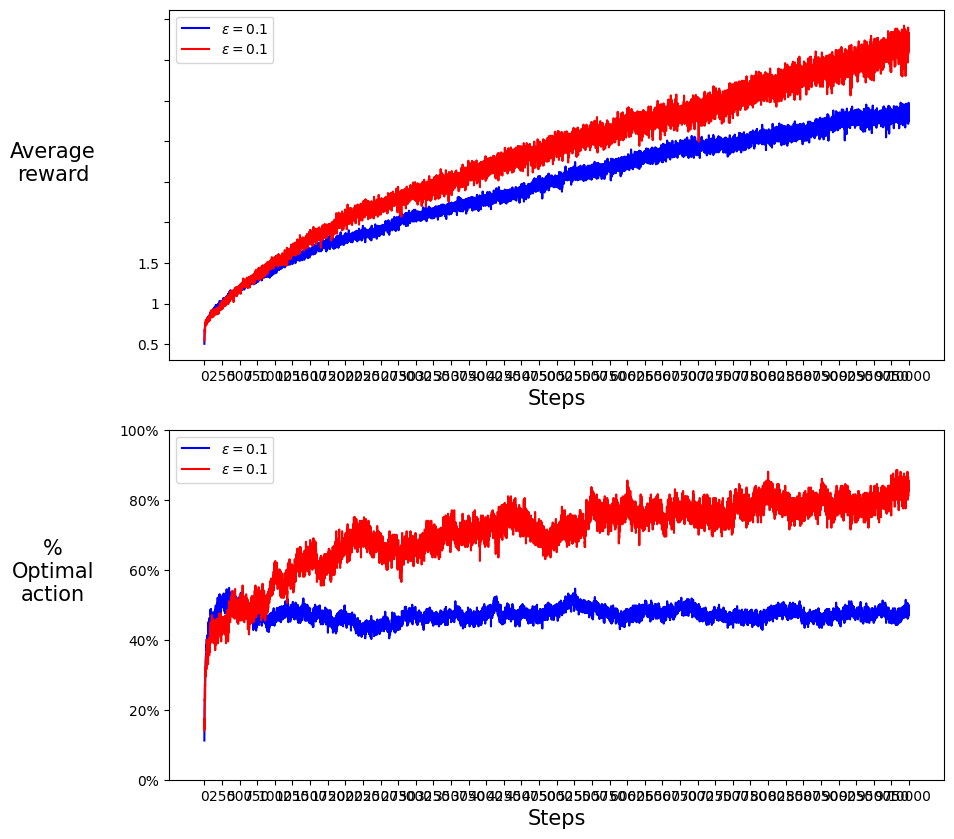

In [233]:
import matplotlib.pyplot as plt

def plot_trajectories_testbed(trajectories: dict[str, np.ndarray], ax=None, param_name: str = None):
    if ax is None:
        _, ax = plt.subplots(nrows=2, figsize=(10,10))
    
    param_name = param_name or 'epsilon'
    
    xticks_ = np.arange(0, 10_000+1, 250)

    colors = ('blue', 'red', 'green')
    for idx, traj_dict in enumerate(trajectories):
        label_ = r"$\varepsilon = $" + str(traj_dict[param_name])
        ax[0].plot(traj_dict['reward'], color=colors[idx], label=label_)
        ax[1].plot(traj_dict['optimal_action'], color=colors[idx], label=label_)

    ax[0].set(yticklabels=[0, 0.5, 1, 1.5], xticks=xticks_, xticklabels=xticks_)
    # ax[0].set(ylim=[0,10.5], yticks=[0, 0.5, 1.0, 1.5], yticklabels=[0, 0.5, 1, 1.5], xticks=xticks_, xticklabels=xticks_)
    ax[0].set_xlabel(xlabel="Steps", fontsize=15)
    ax[0].set_ylabel(ylabel="Average\nreward", rotation=0, fontsize=15)
    ax[0].yaxis.set_label_coords(-.15, .5)
    ax[0].legend()

    yticks_ = np.arange(0, 1.0+.1, .20)
    yticklabels_ = [ f"{int(100*tick)}%" for tick in yticks_]
    ax[1].set(ylim=[0,1.0], yticks=yticks_, yticklabels=yticklabels_, xticks=xticks_, xticklabels=xticks_)
    ax[1].set_xlabel(xlabel="Steps", fontsize=15)
    ax[1].set_ylabel(ylabel="%\nOptimal\naction", rotation=0, fontsize=15)
    ax[1].yaxis.set_label_coords(-.15, .5)
    ax[1].legend()

    plt.show()

plot_trajectories_testbed(trajectories=results,)

# 2.8 Gradient Bandits


In [311]:
class AgentGradientBandit:
    """Gradient Bandit agent."""
    def __init__(self, k, alpha=None, baseline: bool=True):
        self.h = np.zeros(k)
        self.n = np.zeros(k)
        self.k = k
        self.alpha = alpha
        # track baseline
        self.baseline = baseline
        self.__r_obs_avg = 0
        self.__n_obs_tot = 0

    @property
    def pi(self):
        """Boltzmann/soft-max/Gibbs distribution"""
        return np.exp(self.h) / np.sum(np.exp(self.h))
    
    @property
    def r_bar(self):
        return self.__r_obs_avg if self.baseline else 0

    def reset(self):
        self.q = np.zeros(k)
        self.n = np.zeros(k)

    def policy(self, observation=None):
        """Given an observation of the environment's state, determine how to act.
        For gradient bandit, we use soft-max distribution.
        """
        return np.random.choice(a=range(self.k), p=self.pi)
    
    def update_h(self, action, obs_reward):
        """Update the agent's preference H(a) based on an observed reward."""
        # update observed reward average
        self.__n_obs_tot += 1
        self.__r_obs_avg += (obs_reward - self.__r_obs_avg) / self.__n_obs_tot
        
        # Compute new preference values
        pi = self.pi
        h_new = np.zeros(len(self.h))
        for a_idx in range(len(self.h)):
            if a_idx == action:
                h_new[a_idx] = self.h[a_idx] + self.alpha * (obs_reward - self.r_bar) * (1 - pi[a_idx])
            else:
                h_new[a_idx] = self.h[a_idx] - self.alpha * (obs_reward - self.r_bar) * pi[a_idx]
        
        self.h = h_new


In [306]:
results = []
n_steps = 1000
# sample averaging
    
k = 10
n_runs = 2_000
for baseline in (True, False):
    for alpha in (0.1, 0.4):
        # perform runs
        traj_accum = {
            'reward': np.zeros(n_steps),
            'optimal_action': np.zeros(n_steps),
        }
        for i_run in range(n_runs):
            env = KArmedTestbed(k, mean_baseline=+4)
            agent = AgentGradientBandit(k=k, alpha=alpha, baseline=baseline)
            traj = simulate_run(env, agent)
            # record run results
            traj_accum['reward'] += traj['reward']
            traj_accum['optimal_action'] += traj['optimal_action']

        traj_accum['reward'] /= n_runs
        traj_accum['optimal_action'] /= n_runs
        traj_accum['alpha'] = alpha
        traj_accum['baseline'] = baseline
        results.append(traj_accum)

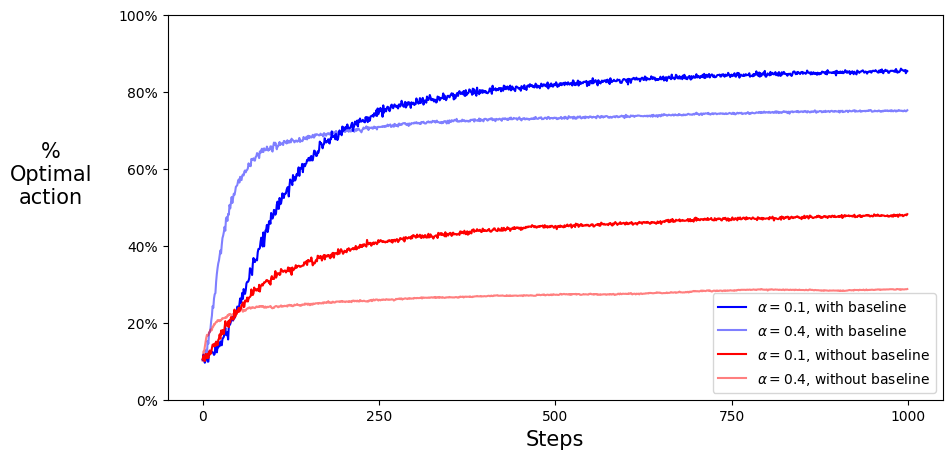

In [307]:
_, ax = plt.subplots(nrows=1, figsize=(10,5))


xticks_ = np.arange(0, 1_000+1, 250)


for idx, traj_dict in enumerate(results):
    bl_ = ", with baseline" if traj_dict['baseline'] else ", without baseline"
    label_ = r"$\alpha = $" + str(traj_dict['alpha']) + bl_
    color = 'blue' if traj_dict['baseline'] else 'red'
    alpha_ = 1.0 if traj_dict['alpha'] == 0.1 else 0.5

    ax.plot(traj_dict['optimal_action'], label=label_, color=color, alpha=alpha_)

yticks_ = np.arange(0, 1.0+.1, .20)
yticklabels_ = [ f"{int(100*tick)}%" for tick in yticks_]
ax.set(ylim=[0,1.0], yticks=yticks_, yticklabels=yticklabels_, xticks=xticks_, xticklabels=xticks_)
ax.set_xlabel(xlabel="Steps", fontsize=15)
ax.set_ylabel(ylabel="%\nOptimal\naction", rotation=0, fontsize=15)
ax.yaxis.set_label_coords(-.15, .5)
ax.legend()

plt.show()

# 2.10 Parameter Study

In [308]:

n_runs = 500 # num runs per eps
n_steps = 1000 # num steps per run

results = []
k = 10

for eps in (1/128, 1/64, 1/32, 1/16, 1/8, 1/4):
    traj_accum = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps),
    }
    for i_run in range(n_runs):

        # perform a run
        env = KArmedTestbed(k)
        agent = AgentEpsGreedy(k, eps)
        traj = simulate_run(env, agent)
        # record run results
        traj_accum['reward'] += traj['reward']
        traj_accum['optimal_action'] += traj['optimal_action']

    traj_accum['reward'] /= n_runs
    traj_accum['optimal_action'] /= n_runs
    traj_accum['epsilon'] = eps

    results.append({
        'epsilon': eps,
        'avg_reward': traj_accum['reward'].mean(),
    })

In [309]:
n_runs = 2000 # num runs per eps
n_steps = 1000 # num steps per run

results2 = []
k = 10

for q0 in (1/4, 1/2, 1, 2, 4):
    traj_accum = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps),
    }
    for i_run in range(n_runs):

        # perform a run
        env = KArmedTestbed(k)
        agent = AgentEpsGreedy(k, eps=0, alpha=0.1, q0=q0)
        traj = simulate_run(env, agent)
        # record run results
        traj_accum['reward'] += traj['reward']
        traj_accum['optimal_action'] += traj['optimal_action']

    traj_accum['reward'] /= n_runs
    traj_accum['optimal_action'] /= n_runs
    traj_accum['q0'] = q0

    results2.append({
        'q0': q0,
        'avg_reward': traj_accum['reward'].mean(),
    })

In [317]:
n_runs = 2000 # num runs per eps
n_steps = 1000 # num steps per run

results3 = []
k = 10

def simulate_run_gb(env, agent):
    n_steps = 1_000
    trajectories = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps, dtype=int),
    }
    for i in range(n_steps):
        # select action
        a = agent.policy()
        # take action
        _, r, _, _ = env.step(a)
        # update agent's internal estimate of Q(a)
        agent.update_h(a, r)

        # update trajectories
        trajectories['reward'][i] = r
        trajectories['optimal_action'][i] = int(a == env.best_action)
    
    return trajectories

for alpha in (1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 3):
    traj_accum = {
        'reward': np.zeros(n_steps),
        'optimal_action': np.zeros(n_steps),
    }
    for i_run in range(n_runs):

        # perform a run
        env = KArmedTestbed(k)
        agent = AgentGradientBandit(k=k, alpha=alpha, baseline=True)
        traj = simulate_run_gb(env, agent)
        # record run results
        traj_accum['reward'] += traj['reward']
        traj_accum['optimal_action'] += traj['optimal_action']

    traj_accum['reward'] /= n_runs
    traj_accum['optimal_action'] /= n_runs
    traj_accum['alpha'] = alpha

    results3.append({
        'alpha': alpha,
        'avg_reward': traj_accum['reward'].mean(),
    })

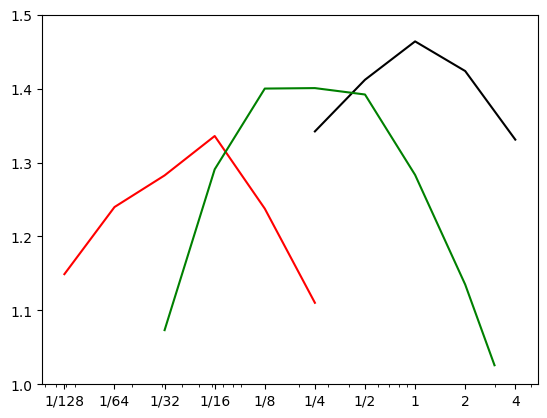

In [318]:
fig, ax = plt.subplots()

eps_ = [r['epsilon'] for r in results]
avgr_ = [r['avg_reward'] for r in results]
ax.semilogx(eps_, avgr_, color='red')

q0_ = [r['q0'] for r in results2]
avgr_ = [r['avg_reward'] for r in results2]
ax.semilogx(q0_, avgr_, color='black')

alpha_ = [r['alpha'] for r in results3]
avgr_ = [r['avg_reward'] for r in results3]
ax.semilogx(alpha_, avgr_, color='green')

xticks_ = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
xticklabels_ = ["1/128", "1/64", "1/32", "1/16", "1/8", "1/4", "1/2", "1", "2", "4"]
ax.set(xticks=xticks_, xticklabels=xticklabels_, ylim=[1, 1.5])
plt.show()

In [316]:
[r['alpha'] for r in results3]

[0.03125, 0.0625, 0.125, 0.25, 0.5]